
📌 RELATÓRIO DE CHURN - TELECOM X

╒═════════════════════════╤═════════╕
│ Métrica                 │   Valor │
╞═════════════════════════╪═════════╡
│ Total de Clientes       │ 7267    │
├─────────────────────────┼─────────┤
│ Clientes com Churn      │ 1869    │
├─────────────────────────┼─────────┤
│ Taxa Geral de Churn (%) │   25.72 │
╘═════════════════════════╧═════════╛

📊 Taxa de Churn por Tipo de Internet

╒════════════════════╤═════════════╕
│ Tipo de Internet   │   Churn (%) │
╞════════════════════╪═════════════╡
│ DSL                │       18.45 │
├────────────────────┼─────────────┤
│ Fiber optic        │       40.56 │
├────────────────────┼─────────────┤
│ No                 │        7.15 │
╘════════════════════╧═════════════╛

⏳ Taxa de Churn por Tempo de Contrato

╒═══════════════════╤═════════════╕
│ Faixa de Tenure   │   Churn (%) │
╞═══════════════════╪═════════════╡
│ 0-12 Meses        │       46.55 │
├───────────────────┼─────────────┤
│ 13-24 Meses       │       28.

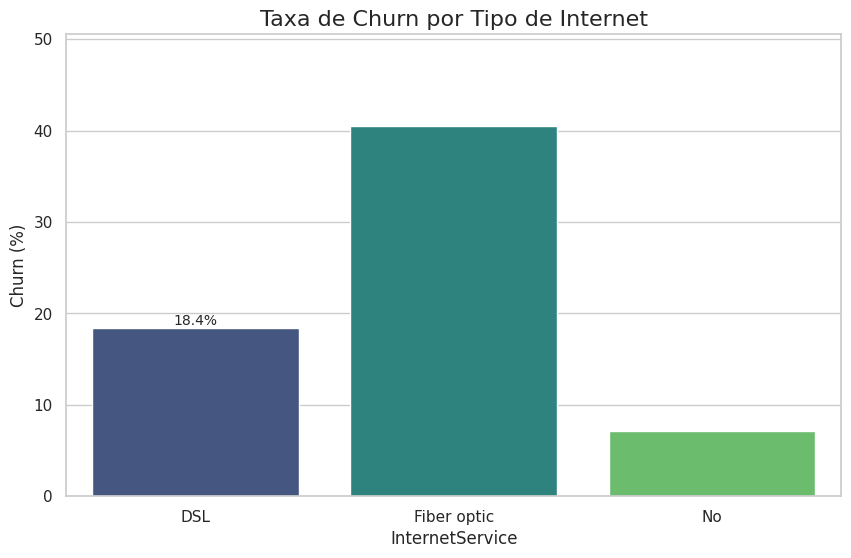

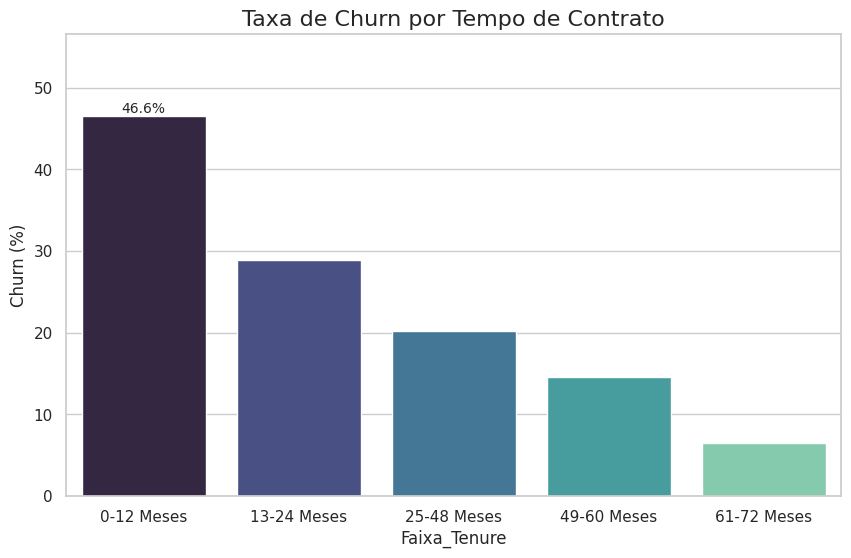

In [40]:
# =========================================================
# 📊 RELATÓRIO DE CHURN - TELECOM X
# =========================================================

import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# -------------------------------
# Configuração visual do Seaborn
# -------------------------------
sns.set_theme(style="whitegrid")
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.figsize'] = (10, 6)

try:
    # === 1. ETAPA DE EXTRAÇÃO ===

    url = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json'
    response = requests.get(url)
    response.raise_for_status()
    dados_json = response.json()
    df = pd.json_normalize(dados_json)

    # === 2. ETAPA DE TRANSFORMAÇÃO ===

    # A. Tratamento de valores vazios na coluna Churn
    df['Churn'] = df['Churn'].replace('', 'No')

    # B. Renomeia colunas
    novos_nomes = {
        'customer.gender': 'Gender',
        'customer.SeniorCitizen': 'SeniorCitizen',
        'customer.Partner': 'Partner',
        'customer.Dependents': 'Dependents',
        'customer.tenure': 'tenure',
        'phone.PhoneService': 'PhoneService',
        'phone.MultipleLines': 'MultipleLines',
        'internet.InternetService': 'InternetService',
        'internet.OnlineSecurity': 'OnlineSecurity',
        'internet.OnlineBackup': 'OnlineBackup',
        'internet.DeviceProtection': 'DeviceProtection',
        'internet.TechSupport': 'TechSupport',
        'internet.StreamingTV': 'StreamingTV',
        'internet.StreamingMovies': 'StreamingMovies',
        'account.Contract': 'Contract',
        'account.PaperlessBilling': 'PaperlessBilling',
        'account.PaymentMethod': 'PaymentMethod',
        'account.Charges.Monthly': 'MonthlyCharges',
        'account.Charges.Total': 'TotalCharges'
    }
    df.rename(columns=novos_nomes, inplace=True)

    # C. Converte Churn para binário
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    # D. Converte TotalCharges para numérico
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

    # E. Normaliza respostas para "No"
    colunas_com_servico = [
        'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
    ]
    for col in colunas_com_servico:
        df[col] = df[col].replace({'No internet service': 'No'})
    df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})

    # F. Converte colunas binárias para 0/1
    colunas_sim_nao = [
        'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling'
    ]
    for coluna in colunas_sim_nao:
        df[coluna] = df[coluna].map({'Yes': 1, 'No': 0})


    # === 3️. RELATÓRIO RESUMIDO ===

    total_clientes = len(df)
    clientes_churn = df['Churn'].sum()
    taxa_churn_geral = (clientes_churn / total_clientes) * 100

    churn_por_internet = df.groupby('InternetService')['Churn'].mean() * 100

    bins = [0, 12, 24, 48, 60, 73]
    labels = ['0-12 Meses', '13-24 Meses', '25-48 Meses', '49-60 Meses', '61-72 Meses']
    df['Faixa_Tenure'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)
    churn_por_tenure = df.groupby('Faixa_Tenure')['Churn'].mean() * 100

    # Impressão com tabulate
    print("\n📌 RELATÓRIO DE CHURN - TELECOM X\n")
    print(tabulate([
        ["Total de Clientes", total_clientes],
        ["Clientes com Churn", clientes_churn],
        ["Taxa Geral de Churn (%)", f"{taxa_churn_geral:.2f}"]
    ], headers=["Métrica", "Valor"], tablefmt="fancy_grid"))

    print("\n📊 Taxa de Churn por Tipo de Internet\n")
    print(tabulate(churn_por_internet.round(2).reset_index().values,
                   headers=["Tipo de Internet", "Churn (%)"], tablefmt="fancy_grid"))

    print("\n⏳ Taxa de Churn por Tempo de Contrato\n")
    print(tabulate(churn_por_tenure.round(2).reset_index().values,
                   headers=["Faixa de Tenure", "Churn (%)"], tablefmt="fancy_grid"))

    # === 4. VISUALIZAÇÕES PROFISSIONAIS ===

    # A. Churn por tipo de Internet

    plt.figure()
    ax = sns.barplot(
        x=churn_por_internet.index,
        y=churn_por_internet.values,
        palette='viridis'
    )
    ax.bar_label(ax.containers[0], fmt="%.1f%%", fontsize=10)
    plt.title('Taxa de Churn por Tipo de Internet')
    plt.ylabel('Churn (%)')
    plt.ylim(0, churn_por_internet.max() + 10)
    plt.show()

    # B. Churn por tempo de contrato
    plt.figure()
    ax = sns.barplot(
        x=churn_por_tenure.index,
        y=churn_por_tenure.values,
        palette='mako'
    )
    ax.bar_label(ax.containers[0], fmt="%.1f%%", fontsize=10)
    plt.title('Taxa de Churn por Tempo de Contrato')
    plt.ylabel('Churn (%)')
    plt.ylim(0, churn_por_tenure.max() + 10)
    plt.show()

except Exception as e:
    print(f"\n❌ ERRO: {e}")

In [2]:

df.to_csv("dados_tratados.csv", index=False)

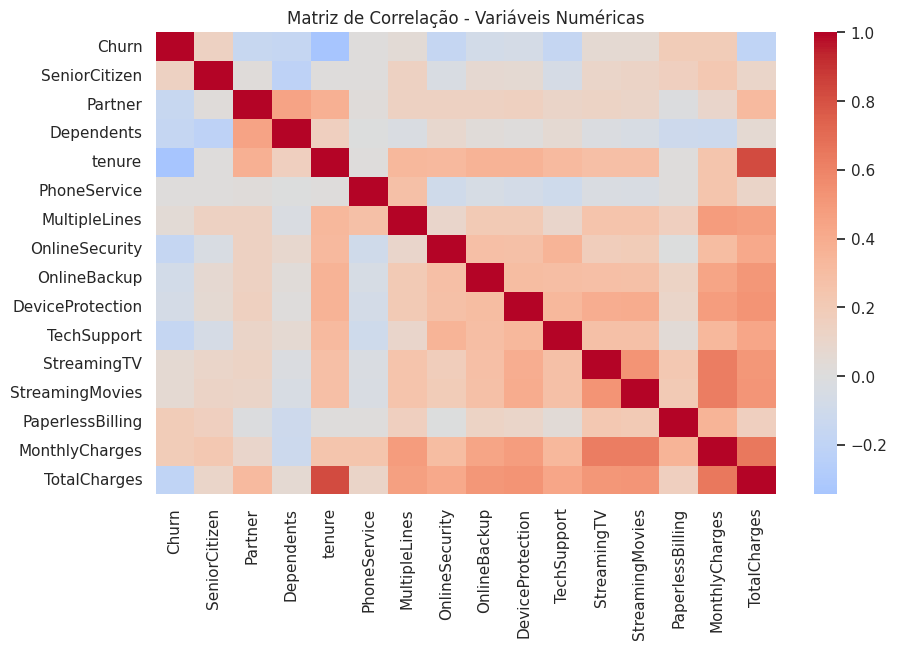


📊 Desempenho dos Modelos:

╒═════════════════════╤════════════╤═════════════╤══════════╤════════════╤═══════════╕
│                     │   Accuracy │   Precision │   Recall │   F1-score │   ROC AUC │
╞═════════════════════╪════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Logistic Regression │      0.803 │       0.638 │    0.543 │      0.587 │     0.844 │
├─────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Random Forest       │      0.782 │       0.593 │    0.487 │      0.535 │     0.819 │
├─────────────────────┼────────────┼─────────────┼──────────┼────────────┼───────────┤
│ KNN                 │      0.757 │       0.529 │    0.489 │      0.508 │     0.769 │
╘═════════════════════╧════════════╧═════════════╧══════════╧════════════╧═══════════╛


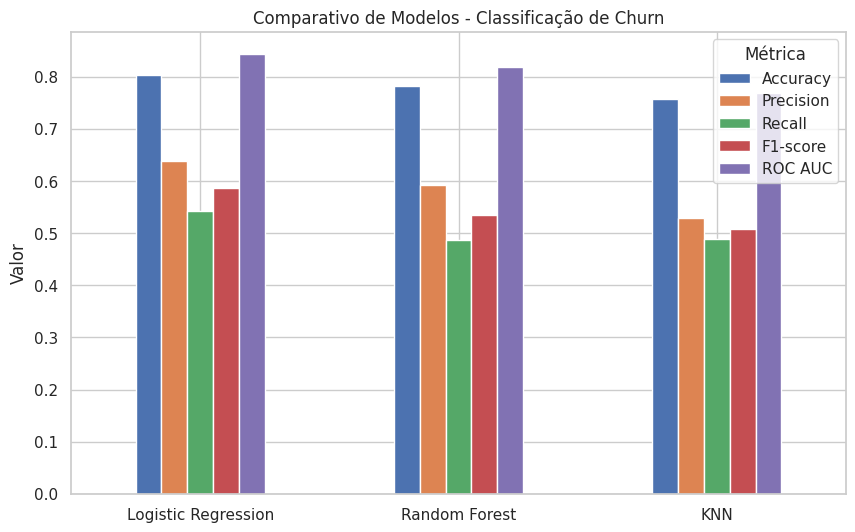


💰 Receita anual em risco: R$ 1,451,542.35
💡 Potencial economia (25% redução churn): R$ 362,885.59

📌 Recomendações Estratégicas:
- Foco em retenção de clientes com < 12 meses de contrato
- Incentivar migração para contratos de longo prazo
- Melhorar serviços de internet de alta velocidade
- Monitoramento preditivo e ofertas personalizadas


In [36]:
# === IMPORTAÇÕES ===
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid", palette="deep")

# === 1. CARREGAMENTO DOS DADOS ===
url = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science/refs/heads/main/TelecomX_Data.json'
dados_json = requests.get(url).json()
df = pd.json_normalize(dados_json)

# Remove colunas irrelevantes
df.drop(columns=['customerID'], inplace=True, errors='ignore')

# === 2. RENOMEAÇÃO E LIMPEZA ===
df.rename(columns={
    'customer.gender':'Gender','customer.SeniorCitizen':'SeniorCitizen','customer.Partner':'Partner',
    'customer.Dependents':'Dependents','customer.tenure':'tenure','phone.PhoneService':'PhoneService',
    'phone.MultipleLines':'MultipleLines','internet.InternetService':'InternetService',
    'internet.OnlineSecurity':'OnlineSecurity','internet.OnlineBackup':'OnlineBackup',
    'internet.DeviceProtection':'DeviceProtection','internet.TechSupport':'TechSupport',
    'internet.StreamingTV':'StreamingTV','internet.StreamingMovies':'StreamingMovies',
    'account.Contract':'Contract','account.PaperlessBilling':'PaperlessBilling',
    'account.PaymentMethod':'PaymentMethod','account.Charges.Monthly':'MonthlyCharges',
    'account.Charges.Total':'TotalCharges'
}, inplace=True)

# Converte churn para binário
df['Churn'] = df['Churn'].replace('', 'No').map({'Yes': 1, 'No': 0})
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

# Normaliza respostas
servicos = ['MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for col in servicos:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

binarias = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
            'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling']
for col in binarias:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# Agrupa tenure
bins = [0,12,24,48,60,73]
labels = ['0-12','13-24','25-48','49-60','61-72']
df['TenureGroup'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)

# === 3. CORRELAÇÃO (VISUAL) ===
plt.figure(figsize=(10,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação - Variáveis Numéricas')
plt.show()

# === 4. PREPARAÇÃO PARA MODELAGEM ===
df_model = pd.get_dummies(df, columns=['Gender','InternetService','Contract','PaymentMethod'], drop_first=False)
X = df_model.drop(['Churn','TenureGroup'], axis=1)
y = df_model['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

numericas = ['tenure','MonthlyCharges','TotalCharges','SeniorCitizen']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numericas] = scaler.fit_transform(X_train[numericas])
X_test_scaled[numericas] = scaler.transform(X_test[numericas])

# === 5. TREINAMENTO E AVALIAÇÃO ===
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=42), True),
    'KNN': (KNeighborsClassifier(), True),
    'Random Forest': (RandomForestClassifier(n_estimators=100, random_state=42), False)
}

results = {}
for name, (model, scale) in models.items():
    Xt, Xv = (X_train_scaled, X_test_scaled) if scale else (X_train, X_test)
    model.fit(Xt, y_train)
    y_pred = model.predict(Xv)
    y_proba = model.predict_proba(Xv)[:,1]
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }

# === 6. VISUALIZAÇÃO PROFISSIONAL DAS MÉTRICAS ===
metrics_df = pd.DataFrame(results).T.sort_values(by='ROC AUC', ascending=False)
print("\n📊 Desempenho dos Modelos:\n")
print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid', floatfmt=".3f"))

metrics_df.plot(kind='bar', figsize=(10,6))
plt.title('Comparativo de Modelos - Classificação de Churn')
plt.ylabel('Valor')
plt.xticks(rotation=0)
plt.legend(title='Métrica')
plt.show()

# === 7. IMPORTÂNCIA DE VARIÁVEIS ===
best_model = metrics_df['ROC AUC'].idxmax()
if best_model == 'Random Forest':
    rf = models['Random Forest'][0]
    importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=importances[:10], y=importances.index[:10], palette='crest')
    plt.title('Top 10 Variáveis Mais Importantes')
    plt.show()

# === 8. IMPACTO FINANCEIRO ===
avg_rev = df['MonthlyCharges'].mean()
annual_risk = avg_rev * df['Churn'].sum() * 12
print(f"\n💰 Receita anual em risco: R$ {annual_risk:,.2f}")
print(f"💡 Potencial economia (25% redução churn): R$ {annual_risk*0.25:,.2f}")

# === 9. RECOMENDAÇÕES ===
print("\n📌 Recomendações Estratégicas:")
print("- Foco em retenção de clientes com < 12 meses de contrato")
print("- Incentivar migração para contratos de longo prazo")
print("- Melhorar serviços de internet de alta velocidade")
print("- Monitoramento preditivo e ofertas personalizadas")
